In [111]:
import pandas as pd
import numpy as np
from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
yf.pdr_override()
from datetime import datetime

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM


In [65]:
def stock_data(stock_name, duration, company_name):#duration in years
   
    end_time = datetime.now()
    start_time = datetime(datetime.now().year - duration, datetime.now().month, datetime.now().day)  #using data of exactly duration year before
    stock=yf.download(stock_name,start_time,end_time)
    stock["comany_name"]=company_name
    return stock

In [66]:
def plot(df, company):
    plt.figure(figsize=(10, 6))
    plt.plot(df.index, df['Adj Close'], color='blue', label='Adjusted Close')
    plt.title(f'Adjusted Close Prices for {company} Inc.')
    plt.xlabel('Date')
    plt.ylabel('Adjusted Close Price')
    plt.legend()  
    plt.grid(True)
    plt.show()

[*********************100%%**********************]  1 of 1 completed


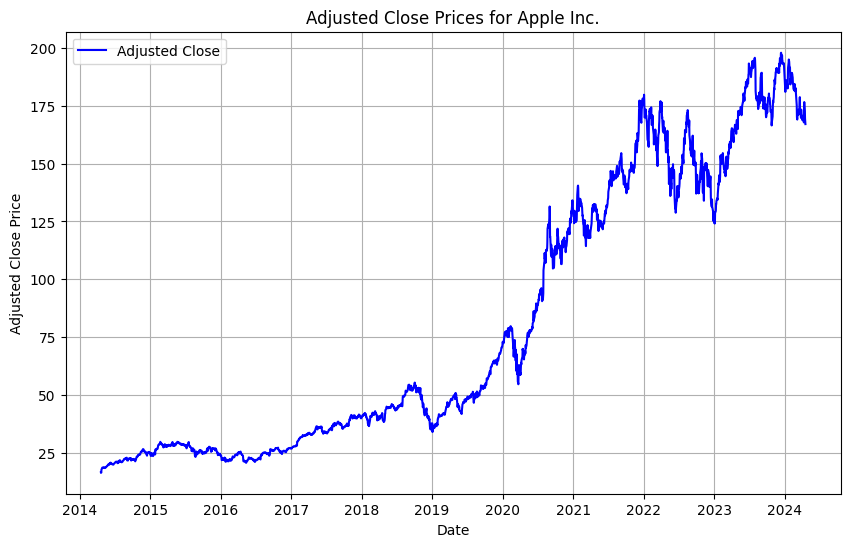

In [85]:
apple_stocks=stock_data('AAPL', 10,'Apple')
plot(apple_stocks,'Apple')

In [86]:
apple_stocks.head()

,Open,High,Low,Close,Adj Close,Volume,comany_name
Date,,,,,,,
2014-04-21,18.762142,19.004999,18.712856,18.970358,16.709385,182548800,Apple
2014-04-22,18.868214,18.993929,18.803572,18.989286,16.726049,202563200,Apple
2014-04-23,18.895000,18.968929,18.730356,18.741072,16.507423,394940000,Apple
2014-04-24,20.293215,20.357143,20.026072,20.277500,17.860733,759911600,Apple
2014-04-25,20.161785,20.428213,20.141430,20.426430,17.991911,390275200,Apple


In [87]:
def minmaxscaling(arr):
    # we are reducing to range (0,1)
    maxi=np.max(np.array(arr).reshape(-1,1))
    mini=np.min(np.array(arr).reshape(-1,1))
    x_std=(arr - mini) / (maxi - mini)
    return x_std

data=minmaxscaling(list(apple_stocks['Close'])).reshape(-1,1)

In [105]:
def split_data(data,percent_split):
    size=(int((np.shape(data)[0])*(percent_split/100)))
    return data[0:size], data[size:]

train_data,test_data=split_data(data, 65)

In [119]:
train_data.shape

(1636, 1)

In [116]:
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [120]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [121]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [118]:
print(X_train.shape), print(y_train.shape)

(1535, 100)
(1535,)


(None, None)

In [113]:
def make_model(step ,numOfStacks, num_neurons):
    model=Sequential()
    model.add(LSTM(num_neurons[0],return_sequences=True,input_shape=(step,1)))
    for i in range(1,numOfStacks):
        model.add(LSTM(num_neurons[i],return_sequences=True))
    model.add(Dense(1))
    return model

In [114]:
step=100
numOfStacks=3
num_neurons=[64,64,50]
model=make_model(step , numOfStacks,num_neurons)
model.compile(loss='mean_squared_error',optimizer='adam')

In [115]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 64)           16896     
                                                                 
 lstm_1 (LSTM)               (None, 100, 64)           33024     
                                                                 
 lstm_2 (LSTM)               (None, 100, 50)           23000     
                                                                 
 dense (Dense)               (None, 100, 1)            51        
                                                                 
Total params: 72971 (285.04 KB)
Trainable params: 72971 (285.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [122]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100

24/24 [==============================] - 9s 160ms/step - loss: 0.0166 - val_loss: 0.3382
Epoch 2/100
24/24 [==============================] - 3s 109ms/step - loss: 0.0141 - val_loss: 0.4096
Epoch 3/100
24/24 [==============================] - 2s 102ms/step - loss: 0.0140 - val_loss: 0.4404
Epoch 4/100
24/24 [==============================] - 2s 103ms/step - loss: 0.0140 - val_loss: 0.4204
Epoch 5/100
24/24 [==============================] - 2s 102ms/step - loss: 0.0139 - val_loss: 0.3808
Epoch 6/100
24/24 [==============================] - 2s 102ms/step - loss: 0.0140 - val_loss: 0.4161
Epoch 7/100
24/24 [==============================] - 2s 102ms/step - loss: 0.0139 - val_loss: 0.3997
Epoch 8/100
24/24 [==============================] - 2s 103ms/step - loss: 0.0140 - val_loss: 0.3917
Epoch 9/100
24/24 [==============================] - 3s 111ms/step - loss: 0.0139 - val_loss: 0.4169
Epoch 10/100
24/24 [==============================] - 3s 112ms/step - loss: 0.0139 - val_l

In [ ]:
def make_data(df,steps):
    
